This notebook visualises the transcribed teams among the other teams in the feature space spanned by task performance and learning outcome, as well as the distribution of their number of attempts and turns.

In [1]:
import os
import sys
import re
import pickle
import datetime

import pathlib as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

from read_utils import get_team_no_from_transcript_filename

sns.set_theme(
    context='paper',
    font_scale=1.5,
    rc={'text.usetex': True})

## Define paths.

In [2]:
# Inputs.
data_dir = pl.Path('../data')

transcripts_dir = data_dir.joinpath('transcripts')

processed_data_dir = pl.Path('../processed_data')
log_features_file = processed_data_dir.joinpath(
    'log_features/justhink19_log_features_task_level.csv')
learning_file = processed_data_dir.joinpath(
    'learning_features/justhink19_learning_features.csv')

# Outputs.
plots_dir = pl.Path('../figures')
perf_vs_learning_file = plots_dir.joinpath('performance_vs_learning.png')

# Create output directories if they do not exist.
for folder in [plots_dir]:
    if not folder.exists():
        folder.mkdir(parents=True)

## Load data.

### Read learning data.

In [3]:
learning_df = pd.read_csv(learning_file, index_col='team_no')

learning_df.head()

,A_RLG,B_RLG,RLG,A_pretest,A_posttest,B_pretest,B_posttest
team_no,,,,,,,
6,-0.200000,0.000000,-0.100000,0.5,0.4,0.6,0.6
7,0.000000,0.285714,0.142857,0.7,0.7,0.3,0.5
8,0.200000,-0.375000,-0.087500,0.5,0.6,0.8,0.5
9,0.200000,0.250000,0.225000,0.5,0.6,0.6,0.7
10,0.333333,0.400000,0.366667,0.4,0.6,0.5,0.7


### Read task features data (at the team level).

In [4]:
task_df = pd.read_csv(log_features_file, index_col='team_no')

task_df.head()

,corpus_no,last_error,max_error,min_error,range_error,avg_error,std_error,noninc_error,slope_error,success,...,avg_action_per_turn,num_turn,num_action,duration,num_edit,freq_add,freq_histload,num_submitselect,num_histview,num_help
team_no,,,,,,,,,,,,,,,,,,,,,
6,1,0.000000,0.090909,0.000000,0.090909,0.045455,0.045455,True,-11.000000,True,...,3.571429,28,100,1350.461,56,0.660714,0.000000,9,5,3
7,1,0.136364,1.909091,0.136364,1.772727,0.505051,0.505908,False,-6.363863,False,...,4.285714,98,420,1581.128,206,0.922330,0.208333,9,24,8
8,1,0.409091,0.500000,0.136364,0.363636,0.308081,0.114948,False,9.555985,False,...,5.057692,52,263,1559.334,107,0.897196,0.000000,0,28,14
9,1,0.318182,0.363636,0.045455,0.318182,0.234848,0.103041,False,-20.335135,False,...,7.823529,34,266,2152.799,68,0.720588,0.645161,0,31,6
10,1,0.454545,0.681818,0.136364,0.545455,0.318182,0.202430,False,-8.873950,False,...,5.882353,51,300,1375.537,108,0.981481,0.275862,1,29,21


### Find dialogue transcripts.

In [5]:
transcript_files = sorted([f for f in transcripts_dir.glob('*.csv')])
transcript_files = {get_team_no_from_transcript_filename(f):f for f in transcript_files}

transcript_files

{7: PosixPath('../data/transcripts/justhink19_transcript_07.csv'),
 8: PosixPath('../data/transcripts/justhink19_transcript_08.csv'),
 9: PosixPath('../data/transcripts/justhink19_transcript_09.csv'),
 10: PosixPath('../data/transcripts/justhink19_transcript_10.csv'),
 11: PosixPath('../data/transcripts/justhink19_transcript_11.csv'),
 17: PosixPath('../data/transcripts/justhink19_transcript_17.csv'),
 18: PosixPath('../data/transcripts/justhink19_transcript_18.csv'),
 20: PosixPath('../data/transcripts/justhink19_transcript_20.csv'),
 28: PosixPath('../data/transcripts/justhink19_transcript_28.csv'),
 47: PosixPath('../data/transcripts/justhink19_transcript_47.csv')}

In [6]:
transcribed_teams = sorted(transcript_files.keys())
transcribed_teams

[7, 8, 9, 10, 11, 17, 18, 20, 28, 47]

### Generate team list that have audio recordings.

In [7]:
with_audio_teams = list(learning_df.index)

# We do not have complete audio recordings for team 33.
with_audio_teams.remove(33) 

print('Audio recordings for {} out of {} teams exist.'.format(
    len(with_audio_teams), len(learning_df)))

Audio recordings for 38 out of 39 teams exist.


## Print the total task duration in hours for all data.

In [8]:
values = [td / 60 / 60 for td in task_df['duration']]
sum(values)

15.926999166666665

## Visualise teams in learning vs. performance space.

### Make the input table for the plot.

In [9]:
# Put performance metric values on the x axis.
perf_col = 'min_error'
x_values = task_df[perf_col] 

# Put learning metric values on the y axis.
learn_col = 'RLG'
y_values = learning_df[learn_col]


# Merge the tables.
df = pd.concat([x_values, y_values], axis=1)

# Omit the teams that do not have the audio transcripts.
df = df.loc[df.index.isin(with_audio_teams)]

# Assign a type for each team, depending on if it is transcribed or not.
df['kind'] = ['transcribed subset' if t in transcribed_teams else 'other'
              for t in df.index]

# Scale by 100 to represent percentages.
def scale_hundred(x): return 100 * x
df.min_error = df.min_error.apply(scale_hundred)
df.RLG = df.RLG.apply(scale_hundred)

df

,min_error,RLG,kind
team_no,,,
6,0.000000,-10.0000,other
7,13.636364,14.2857,transcribed subset
8,13.636364,-8.7500,transcribed subset
9,4.545455,22.5000,transcribed subset
10,13.636364,36.6667,transcribed subset
11,4.545455,36.6667,transcribed subset
12,4.545455,25.0000,other
14,13.636364,-14.2857,other
15,22.727273,-2.0833,other


### Generate the plot.

Plot is exported to ../figures/performance_vs_learning.pdf


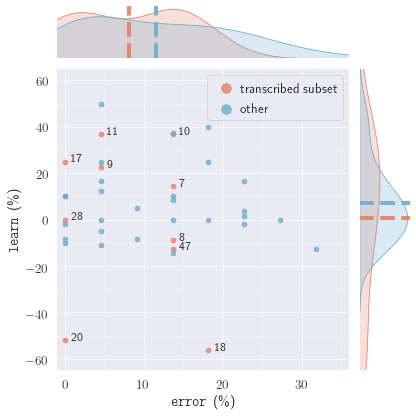

In [10]:
def plot_perf_vs_error(col_x,
                       col_y,
                       col_k,
                       df,
                       k_is_color=False,
                       colors=['#e48066', '#6bacd1'],
                       scatter_alpha=.8):

    def colored_scatter(x, y, c=None, label=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            kwargs['label'] = label
            plt.scatter(*args, **kwargs)

        return scatter

    df = df.copy()
    col_x = col_x.replace('_', '\_')
    col_y = col_y.replace('_', '\_')
    df.columns = [c.replace('_', '\_') for c in df.columns]

    prev_x_counts = None
    prev_y_counts = None

    step = 10
    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        xlim=[-1, 35 + 1],
        ylim=[-60 - step / 2, 60 + step / 2],
        data=df,
    )

    sns.despine(ax=g.ax_joint, left=True)

    color = None
    legends = []
    handles = []
    for i, (name, df_group) in enumerate(reversed(tuple(df.groupby(col_k)))):
        legends.append(name)
        if k_is_color:
            color = name

        g.plot_joint(colored_scatter(df_group[col_x], df_group[col_y], colors[i],
                                     label=name))

        # Plot performance.
        # Draw a KDE plot.
        sns.kdeplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=colors[i],
            shade=True,
        )
        # Draw the mean line segments.
        m = np.mean(df_group[col_x])
        g.ax_marg_x.axvline(
            m,
            ls='--',
            lw=4,
            c=colors[i],
            alpha=0.9,
        )

        # Plot learning.
        # Draw a KDE plot.
        sns.kdeplot(
            y=df_group[col_y].values,
            ax=g.ax_marg_y,
            color=colors[i],
            shade=True,
        )
        # Draw the mean line segments.
        m = np.mean(df_group[col_y])
        g.ax_marg_y.axhline(
            m,
            ls='--',
            lw=4,
            c=colors[i],
            alpha=0.9,
        )

    # Adjust the legend.
    g.ax_joint.legend(markerscale=2, handletextpad=0.1)
    g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator(n=2))

    # Adjust the grid.
    plt.grid(alpha=0.85)
    plt.grid(which='minor', alpha=0.3)

    # Adjust the background colors.
    g.ax_marg_x.set_facecolor('white')
    g.ax_marg_y.set_facecolor('white')

    # Add annotations one by one with a loop.
    takens = dict()
    for i, row in df.iterrows():
        if row['kind'] != 'transcribed subset':
            continue
        offset = 0.8
        plt.text(
            row[col_x] + offset, row[col_y], str(i),
            fontsize='small',
        )

    # Set axis labels.
    # g.ax_joint.set_xlabel(r"minimum error \texttt{error} (\%)")
    # g.ax_joint.set_ylabel(r"relative learning gain \texttt{learn} (\%)")
    g.ax_joint.set_xlabel(r"\texttt{error} (\%)")
    g.ax_joint.set_ylabel(r"\texttt{learn} (\%)")

    
    return g


g = plot_perf_vs_error(perf_col, learn_col, 'kind', df=df)

# Export as vector graphics - pdf.
export_file = perf_vs_learning_file.with_suffix('.pdf')
plt.savefig(export_file, bbox_inches='tight')
print('Plot is exported to {}'.format(export_file))

## Visualise the teams in number of attempts and turns.

In [11]:
def feature_value(team_no, feature_name): 
    return task_df.loc[team_no][feature_name]


def learning_value(team_no, feature_name): 
    return learning_df.loc[team_no, feature_name]

In [12]:
def plot_hist(f_name, bins=10,
              func=feature_value, legend=True, ax=None,
              colors=['#6bacd1', '#e48066'],
              n_xminor=2, save=False):

    values_1 = [func(t, f_name)
                for t in with_audio_teams if t not in transcribed_teams]
    values_2 = [func(t, f_name) for t in transcribed_teams]
    
    if ax is None:
        fig, ax = plt.subplots(tight_layout=True)
    else:
        fig = None

    labels = ['other', 'transcribed subset']

    ax.hist(
        [values_1, values_2],  # , values_3],
        bins,
        histtype='barstacked',
        color=colors,
        label=labels,
        align='mid',
        edgecolor='k', alpha=0.5,
    )

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], framealpha=1)

    m1, m2 = np.mean(values_1), np.mean(values_2)
    ymin, ymax = 0, 1
    ax.axvline(m1, ymax=ymax, c=colors[0], ls='--', lw=6, alpha=0.9)

    ymin = 0.05
    ax.axvline(m2, ymin=ymin, ymax=ymax, c=colors[1], ls='--', lw=6, alpha=0.9)

    ax.grid(alpha=0.9)
    ax.grid(which='minor', alpha=0.5)

    ax.set_ylabel('team count')
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=n_xminor))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))

    if fig is not None and save:
        export_file = plots_dir.joinpath('hist_{}.png'.format(f_name.lower()))
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

        export_file = export_file.with_suffix('.pdf')
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

    return fig, ax

# # Try.
# f_name = 'num_attempt'
# step = 1
# bins = np.arange(0 - step / 2, 20 + step / 2, step)
# fig, ax = plot_hist(f_name, bins, legend=False)
# ax.set_xlabel('number of attempts')
# ax.set_xlim([-0.5, 21])
# ax.set_xticks(np.arange(0, 20 + 1, 4))
# ax.set_ylim([0, 10.5])
# ax.set_yticks(np.arange(0, 8.1, 4));

In [13]:
# Set font sizes.
plt.rc('font', size=36)  # controls default text sizes
plt.rc('axes', titlesize=36)  # fontsize of the axes title
plt.rc('axes', labelsize=36)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=36)  # fontsize of the tick labels
plt.rc('ytick', labelsize=36)  # fontsize of the tick labels
plt.rc('legend', fontsize=22)  # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title

../figures/attempt_and_turn_histograms.pdf


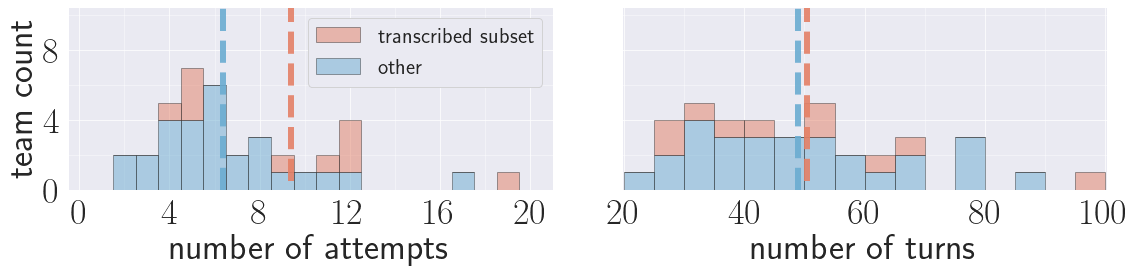

In [14]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 4))

ax = axes[0]
f_name = 'num_attempt'
step = 1
bins = np.arange(0 - step / 2, 20 + step / 2, step)
plot_hist(f_name, bins, legend=True, ax=ax)
ax.set_xlabel('number of attempts')
ax.set_xlim([-0.5, 21])
ax.set_xticks(np.arange(0, 20+1, 4))
ax.set_ylim([0, 10.5])
ax.set_yticks(np.arange(0, 8.1, 4))
ax = axes[1]
f_name = 'num_turn'
step = 5
bmax = 100
bins = np.arange(0, bmax + step, step)
plot_hist(f_name, bins, legend=False, ax=ax)
ax.set_xlabel('number of turns')
ax.set_xlim([20 - 0.3, bmax + 0.3])
ax.set_xticks(np.arange(20, bmax+1, 4*step))
ax.set_ylim([0, 10.5])
ax.set_ylabel('')
ax.set_yticks(np.arange(0, 8.1, 4))


fig.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)

export_file = plots_dir.joinpath('attempt_and_turn_histograms.png')
# # Export png (disabled)
# fig.savefig(export_file, bbox_inches='tight')
# print(export_file)

export_file = export_file.with_suffix('.pdf')
fig.savefig(export_file, bbox_inches='tight')
print(export_file)